In [274]:
import numpy
import pandas
import random
from datetime import datetime
import time
import matplotlib.pyplot as plt

# this tells seaborn and matplotlib to generate plots inline in the notebook
%matplotlib inline  

# these two lines allow you to control the figure size
%pylab inline
pylab.rcParams['figure.figsize'] = (16.0, 8.0) 

# this is our training data
train_data = pandas.read_csv( 'data/ross_store_train.csv' )
randomData = train_data.reindex(numpy.random.permutation(train_data.index))
train_data = randomData[:1000]
 
# these are what we need to make predictions for
test_data = pandas.read_csv( 'data/ross_store_test.csv' )


Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [275]:
def similarity_kernel(x, y):
    #if they're the same, the coorelation is exact and we say there's 0 diff
    if x == y:
        return 1
    #if they're different, we put a big weight on it
    else:
        return 0

#get the difference in dates. The further it is the bigger the number
def date_kernel(x, y, frobVal=0.02):
    days = numpy.abs((unix_from_str(y) - unix_from_str(x)) / (3600 * 24))
    return days * frobVal

def unix_from_str(data):
    return time.mktime(datetime.datetime.strptime(data, '%Y-%m-%d').timetuple()) 

#The bigger the number, the less like each other they are
def composite_kernel(x, y):
    return similarity_kernel( x.Store, y.Store) + similarity_kernel( x.Date, y.Date ) + similarity_kernel( x.DayOfWeek, y.DayOfWeek ) + similarity_kernel( x.Open, y.Open ) + similarity_kernel( x.Promo, y.Promo ) + similarity_kernel( x.StateHoliday, y.StateHoliday ) + similarity_kernel( x.SchoolHoliday, y.SchoolHoliday )

In [276]:
m = 10
n = len(train_data)
train_indeces = xrange(len(train_data))

Kmm = numpy.zeros((m, m))
Kmn = numpy.zeros((m, n))



def populateKmm(Kmm):
    for i in xrange(m):
        for j in xrange(m):
            in1 = random.choice(train_indeces)
            in2 = random.choice(train_indeces)
            Kmm[i,j] = composite_kernel( train_data.iloc[in1], train_data.iloc[in2] )
    return Kmm

def populateKmn(Kmn):
    for i in xrange(m):
        for j in xracnge(n):
            in1 = random.choice(train_indeces)
            Kmn[i,j] = composite_kernel( train_data.iloc[in1], train_data.iloc[j] )
    return Kmn

def generateKtm(testRow):
    Ktm = numpy.zeros((1,m))
    for x in xrange(m):
        in1 = random.choice(train_indeces)
        Ktm[0, x] = composite_kernel(train_data.iloc[in1], testRow)
    return Ktm

Kmm = populateKmm(Kmm)
Kmn = populateKmn(Kmn)
Knm = numpy.transpose(Kmn)

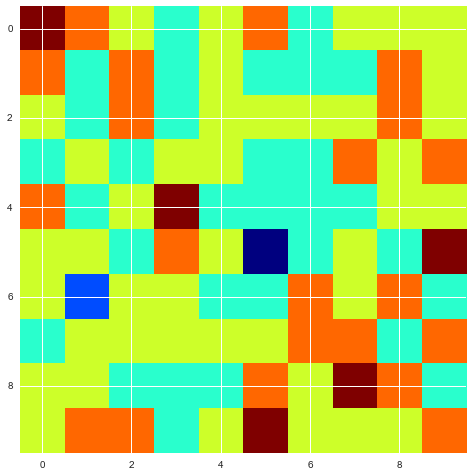

In [277]:
plt.imshow(Kmm.reshape(m,m).T, interpolation='nearest',cmap='jet')

In [280]:
Y = train_data.Sales

def predict_muPrime(testRow, sigma=1):
    Ktm = generateKtm(testRow)
    return Ktm.dot(numpy.linalg.inv(Kmn.dot(Knm) + (pow(sigma, 2) * Kmm))).dot(Kmn).dot(Y)


In [281]:
N = test_data.shape[0]
my_preds = numpy.zeros(( N, 1 ))

for id in range( 0, N ):
    my_preds[ id, 0 ] = predict_muPrime(test_data.iloc[id])
    
sfile = open( 'mean_sub.csv', 'wb' )
sfile.write( '"Id","Sales"\n' )
for id in range( 0, N ):
    sfile.write( '%d,%.2f\n' % ( id+1, my_preds[id] ) )  # add one for one-based indexing
sfile.close()

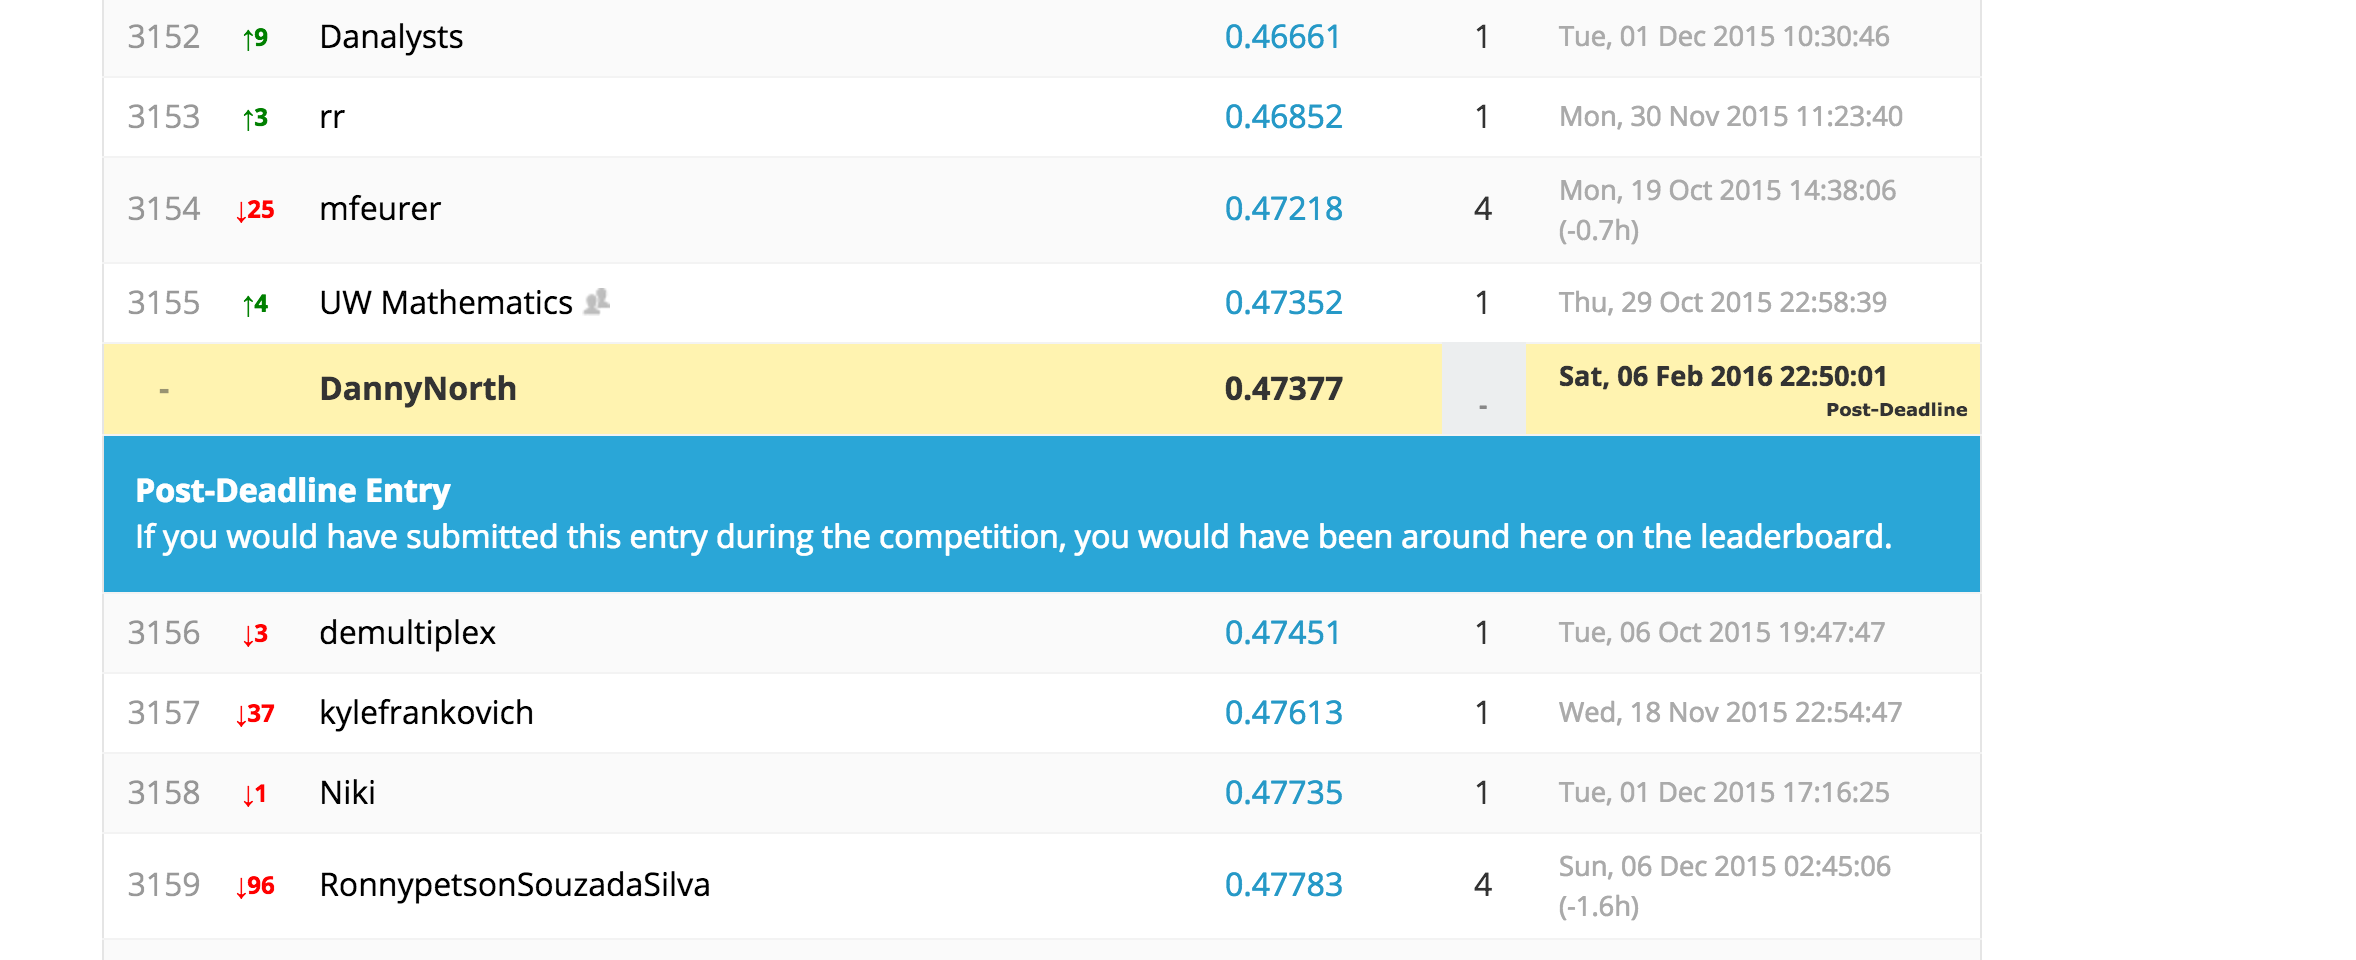

In [282]:
from IPython.display import Image
Image(filename='images/rossman_kaggle.png')